
---

## **📁 File: `02_Data_Cleaning.ipynb`**

# **🧹 02 - Data Cleaning & Preparation**

## **📑 Table of Contents**
1.  [🎯 Objectives](#-objectives)
2.  [⚙️ Setup & Import Functions](#-setup--import-functions)
3.  [📥 Load Raw Data](#-load-raw-data)
4.  [🔧 Apply Cleaning Functions](#-apply-cleaning-functions)
5.  [📊 Verify Cleaning Results](#-verify-cleaning-results)
6.  [💾 Save Cleaned Data](#-save-cleaned-data)

---

## **🎯 Objectives**
- Load the raw data from `dataset/00_raw/`
- Apply text cleaning functions to prepare for NLP
- Handle missing values and data quality issues
- Save cleaned data to `dataset
- /01_interim/` for future use

---



## **⚙️ 1. Setup & Import Functions**


In [1]:

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import sys
import os

# Add the project root directory to Python path
sys.path.append(os.path.abspath('..'))

# Now import your modules
from src.data_cleaning import clean_text, run_clean_pipeline
from src.data_cleaning import gentle_clean_text, basic_clean_text, aggressive_clean_text
from src.data_cleaning import clean_date_column, engineer_text_features, engineer_all_features, handle_duplicates
from src.data_cleaning import analyze_duplicates, handle_duplicates


%matplotlib inline
print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!



---

## **📥 2. Load Raw Data**


In [2]:
# Load the raw datasets
print("Loading raw data...")
raw_df = pd.read_csv('../dataset/00_raw/data.csv')
raw_val_df = pd.read_csv('../dataset/00_raw/validation_data.csv')

print(f"Main dataset shape: {raw_df.shape}")
print(f"Validation dataset shape: {raw_val_df.shape}")

# Display first few rows
print("\nMain dataset preview:")
display(raw_df.head(2))
print("\nValidation dataset preview:")
display(raw_val_df.head(2))


Loading raw data...
Main dataset shape: (39942, 5)
Validation dataset shape: (4956, 5)

Main dataset preview:


,label,title,text,subject,date
0,1,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"



Validation dataset preview:


,label,title,text,subject,date
0,2,UK's May 'receiving regular updates' on London...,LONDON (Reuters) - British Prime Minister Ther...,worldnews,"September 15, 2017"
1,2,UK transport police leading investigation of L...,LONDON (Reuters) - British counter-terrorism p...,worldnews,"September 15, 2017"



---
## 📅 3. Enhanced Date Processing Section


In [3]:
## 📅 DATE COLUMN ANALYSIS & FEATURE ENGINEERING
print("📅 Engineering date features...")

# Apply enhanced date cleaning
raw_df['date_parsed'], raw_df['year'], raw_df['quarter'], raw_df['is_weekend'] = clean_date_column(raw_df['date'])
raw_val_df['date_parsed'], raw_val_df['year'], raw_val_df['quarter'], raw_val_df['is_weekend'] = clean_date_column(raw_val_df['date'])

# Fill missing dates with mode or reasonable defaults
if raw_df['year'].isna().any():
    mode_year = raw_df['year'].mode()[0] if not raw_df['year'].mode().empty else 2017
    raw_df['year'] = raw_df['year'].fillna(mode_year)
    raw_df['quarter'] = raw_df['quarter'].fillna('Q4')  # Most common quarter
    raw_df['is_weekend'] = raw_df['is_weekend'].fillna(False)

# Same for validation set
if raw_val_df['year'].isna().any():
    raw_val_df['year'] = raw_val_df['year'].fillna(mode_year)
    raw_val_df['quarter'] = raw_val_df['quarter'].fillna('Q4')
    raw_val_df['is_weekend'] = raw_val_df['is_weekend'].fillna(False)

print("✅ Date features engineered:")
print(f"   Years: {raw_df['year'].unique()}")
print(f"   Quarters: {raw_df['quarter'].unique()}")
print(f"   Weekend articles: {raw_df['is_weekend'].sum()}")

# Drop the original date column since we have extracted features
raw_df = raw_df.drop(columns=['date', 'date_parsed'])
raw_val_df = raw_val_df.drop(columns=['date', 'date_parsed'])

📅 Engineering date features...
✅ Date features engineered:
   Years: [2017. 2016. 2018. 2015.]
   Quarters: ['Q4.0' 'Q3.0' 'Q2.0' 'Q1.0' 'Q4']
   Weekend articles: 7615



---

## **🔧 3. Apply Cleaning Functions**


In [4]:
# Create copies for different cleaning strategies
df_gentle = raw_df.copy()
df_basic = raw_df.copy() 
df_aggressive = raw_df.copy()

val_gentle = raw_val_df.copy()
val_basic = raw_val_df.copy()
val_aggressive = raw_val_df.copy()

print("Applying different cleaning strategies...")

# Apply GENTLE cleaning (preserves context for embeddings)
df_gentle['clean_title'] = df_gentle['title'].apply(gentle_clean_text)
df_gentle['clean_text'] = df_gentle['text'].apply(gentle_clean_text)
val_gentle['clean_title'] = val_gentle['title'].apply(gentle_clean_text)
val_gentle['clean_text'] = val_gentle['text'].apply(gentle_clean_text)

# Apply BASIC cleaning (for sentence transformers)
df_basic['clean_title'] = df_basic['title'].apply(basic_clean_text)
df_basic['clean_text'] = df_basic['text'].apply(basic_clean_text)
val_basic['clean_title'] = val_basic['title'].apply(basic_clean_text)
val_basic['clean_text'] = val_basic['text'].apply(basic_clean_text)

# Apply AGGRESSIVE cleaning (for traditional NLP)
df_aggressive['clean_title'] = df_aggressive['title'].apply(aggressive_clean_text)
df_aggressive['clean_text'] = df_aggressive['text'].apply(aggressive_clean_text)
val_aggressive['clean_title'] = val_aggressive['title'].apply(aggressive_clean_text)
val_aggressive['clean_text'] = val_aggressive['text'].apply(aggressive_clean_text)

# # Drop date column from all datasets (as recommended from EDA)
# datasets = [df_gentle, df_basic, df_aggressive, val_gentle, val_basic, val_aggressive]
# for dataset in datasets:
#     if 'date' in dataset.columns:
#         dataset.drop(columns=['date'], inplace=True)

print("✅ All cleaning strategies completed!")

Applying different cleaning strategies...
✅ All cleaning strategies completed!



---

## **📊 4. Verify Cleaning Results**


In [5]:
print("CLEANING VERIFICATION:")
print("=" * 50)

# Compare different cleaning strategies on same example
# example_text = "U.S. military to accept transgender recruits on Monday: Pentagon"
example_text = "WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. "


print("Original:", example_text)
print("Gentle:", gentle_clean_text(example_text))
print("Basic:", basic_clean_text(example_text)) 
print("Aggressive:", aggressive_clean_text(example_text))
print()

# Check dataset info
print("Dataset shapes after cleaning:")
print(f"Gentle: {df_gentle.shape}")
print(f"Basic: {df_basic.shape}")
print(f"Aggressive: {df_aggressive.shape}")

# Check first few rows of each
print("\nSample cleaned titles (first 2 rows):")
print("\nGENTLE cleaning:")
for i in range(2):
    print(f"  {df_gentle['clean_title'].iloc[i][:100]}...")

print("\nBASIC cleaning:")
for i in range(2):
    print(f"  {df_basic['clean_title'].iloc[i][:100]}...")

print("\nAGGRESSIVE cleaning:")
for i in range(2):
    print(f"  {df_aggressive['clean_title'].iloc[i][:100]}...")

CLEANING VERIFICATION:
Original: WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. 
Gentle: WASHINGTON Reuters The head of a conservative Republican faction in the U.S. Congress who voted this month for a huge expansion of the national debt to pay for tax cuts called himself a fiscal conservative on Sunday and urged budget restraint in .
Basic: washington reuters the head of a conservative republican faction in the u.s. congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a fiscal conservative on sunday and urged budget restraint in 2018.
Aggressive: washington reuters the head conservative republican faction the congress who voted this month for huge expansion the national debt pay for tax cuts called himself fiscal conserv

---
## 🧹 Step Enhanced Data Cleaning Pipeline


In [6]:
## 🧹 Duplicate Handling Strategy
print("🧹 Implementing duplicate handling strategy...")
print("=" * 50)

# Apply duplicate handling to all datasets (on Title)
print("Applying duplicate handling to training data...")
df_gentle = handle_duplicates(df_gentle, strategy='remove', subset=['title'])
df_basic = handle_duplicates(df_basic, strategy='remove', subset=['title']) 
df_aggressive = handle_duplicates(df_aggressive, strategy='remove', subset=['title'])

# Apply duplicate handling to all datasets (on Text)
df_gentle = handle_duplicates(df_gentle, strategy='remove', subset=['text'])
df_basic = handle_duplicates(df_basic, strategy='remove', subset=['text']) 
df_aggressive = handle_duplicates(df_aggressive, strategy='remove', subset=['text'])

# print("Applying duplicate handling to validation data...")
# val_gentle = handle_duplicates(val_gentle, strategy='remove', subset=['title'])
# val_basic = handle_duplicates(val_basic, strategy='remove', subset=['title'])
# val_aggressive = handle_duplicates(val_aggressive, strategy='remove', subset=['title'])

print("✅ Duplicate handling completed!")
print(f"New dataset sizes:")
print(f"  Gentle: {len(df_gentle)} (was {len(raw_df)})")
print(f"  Basic: {len(df_basic)} (was {len(raw_df)})")
print(f"  Aggressive: {len(df_aggressive)} (was {len(raw_df)})")

🧹 Implementing duplicate handling strategy...
Applying duplicate handling to training data...
Removing 3859 duplicates based on ['title']
Removing 3859 duplicates based on ['title']
Removing 3859 duplicates based on ['title']
Removing 452 duplicates based on ['text']
Removing 452 duplicates based on ['text']
Removing 452 duplicates based on ['text']
✅ Duplicate handling completed!
New dataset sizes:
  Gentle: 35631 (was 39942)
  Basic: 35631 (was 39942)
  Aggressive: 35631 (was 39942)


In [7]:
analyze_duplicates(df_gentle)

{'exact_duplicates': 0,
 'title_duplicates': 0,
 'text_duplicates': 0,
 'conflicting_titles': 0,
 'conflicting_texts': 0}

## 📝 5. Essential Text Feature Engineering

In [8]:
## 📝 DERIVED TEXT FEATURES
print("📝 Engineering essential text features...")

def add_essential_features(dataframe):
    """Add essential derived text features including capitalization and special symbols analysis"""
    df_copy = dataframe.copy()
    
    # Basic text length features
    df_copy['title_length'] = df_copy['title'].str.len().fillna(0)
    df_copy['title_word_count'] = df_copy['title'].str.split().str.len().fillna(0)
    df_copy['text_length'] = df_copy['text'].str.len().fillna(0)
    df_copy['text_word_count'] = df_copy['text'].str.split().str.len().fillna(0)
    
    # Capitalization analysis
    df_copy['title_capitals'] = df_copy['title'].apply(
        lambda x: sum(1 for char in str(x) if char.isupper()) if pd.notna(x) else 0
    )
    df_copy['text_capitals'] = df_copy['text'].apply(
        lambda x: sum(1 for char in str(x) if char.isupper()) if pd.notna(x) else 0
    )
    df_copy['title_capitals_ratio'] = df_copy['title_capitals'] / df_copy['title_length'].replace(0, 1)
    df_copy['text_capitals_ratio'] = df_copy['text_capitals'] / df_copy['text_length'].replace(0, 1)
    
    # Special symbols analysis (common in sensational/fake news)
    # Use raw strings (r'') to avoid escape sequence warnings
    df_copy['title_exclamation'] = df_copy['title'].str.count('!').fillna(0)
    df_copy['text_exclamation'] = df_copy['text'].str.count('!').fillna(0)
    
    df_copy['title_question'] = df_copy['title'].str.count(r'\?').fillna(0)  # Fixed escape
    df_copy['text_question'] = df_copy['text'].str.count(r'\?').fillna(0)    # Fixed escape
    
    df_copy['title_quotes'] = df_copy['title'].str.count('"').fillna(0) + df_copy['title'].str.count("'").fillna(0)
    df_copy['text_quotes'] = df_copy['text'].str.count('"').fillna(0) + df_copy['text'].str.count("'").fillna(0)
    
    # Dollar signs and numbers (common in clickbait)
    df_copy['title_dollar'] = df_copy['title'].str.count(r'\$').fillna(0)    # Fixed escape
    df_copy['text_dollar'] = df_copy['text'].str.count(r'\$').fillna(0)      # Fixed escape
    
    df_copy['title_numbers'] = df_copy['title'].str.count(r'\d').fillna(0)
    df_copy['text_numbers'] = df_copy['text'].str.count(r'\d').fillna(0)
    
    # ALL CAPS words detection (common in sensational headlines)
    df_copy['title_all_caps_words'] = df_copy['title'].apply(
        lambda x: len(re.findall(r'\b[A-Z]{3,}\b', str(x))) if pd.notna(x) else 0
    )
    df_copy['text_all_caps_words'] = df_copy['text'].apply(
        lambda x: len(re.findall(r'\b[A-Z]{3,}\b', str(x))) if pd.notna(x) else 0
    )
    
    # Sensational language indicators
    sensational_words = [
        'shocking', 'amazing', 'incredible', 'unbelievable', 'secret', 
        'exposed', 'revealed', 'warning', 'alert', 'breaking', 'urgent',
        'you won\'t believe', 'this will shock you', 'doctors hate',
        'what happened next', 'gone viral', 'viral'
    ]
    
    df_copy['title_sensational_count'] = df_copy['title'].apply(
        lambda x: sum(1 for word in sensational_words if word in str(x).lower()) if pd.notna(x) else 0
    )
    df_copy['text_sensational_count'] = df_copy['text'].apply(
        lambda x: sum(1 for word in sensational_words if word in str(x).lower()) if pd.notna(x) else 0
    )
    
    # Composite sensational score
    df_copy['sensational_score'] = (
        df_copy['title_exclamation'] + 
        df_copy['title_question'] * 0.5 +
        df_copy['title_all_caps_words'] * 2 +
        df_copy['title_sensational_count'] * 3 +
        df_copy['title_capitals_ratio'] * 10
    )
    
    return df_copy

# Apply to all datasets
print("🔄 Adding features to all dataset versions...")

df_gentle = add_essential_features(df_gentle)
df_basic = add_essential_features(df_basic)
df_aggressive = add_essential_features(df_aggressive)

val_gentle = add_essential_features(val_gentle)
val_basic = add_essential_features(val_basic) 
val_aggressive = add_essential_features(val_aggressive)

print("✅ Essential features added to all datasets")

📝 Engineering essential text features...
🔄 Adding features to all dataset versions...
✅ Essential features added to all datasets


## 🔍 6. Feature Overview & Validation

In [9]:
## 🔍 FEATURE OVERVIEW
print("\n🔍 Final Feature Overview")
print("=" * 50)

# Display feature summary for each dataset type
datasets = [df_gentle, df_basic, df_aggressive]
names = ['Gentle', 'Basic', 'Aggressive']

for i, (dataset, name) in enumerate(zip(datasets, names)):
    print(f"\n📊 {name} Cleaning Dataset:")
    print(f"   Shape: {dataset.shape}")
    print(f"   Columns: {list(dataset.columns)}")
    
    # Sample feature stats
    if i == 0:  # Only show for first dataset to avoid repetition
        print(f"   Title length: {dataset['title_length'].mean():.1f} ± {dataset['title_length'].std():.1f} chars")
        print(f"   Text length: {dataset['text_length'].mean():.1f} ± {dataset['text_length'].std():.1f} chars")
        print(f"   Valid years: {dataset['year'].notna().sum()} ({dataset['year'].notna().mean():.1%})")
        print(f"   Weekend articles: {dataset['is_weekend'].sum()} ({dataset['is_weekend'].mean():.1%})")

# Verify we have the exact features we want
expected_features = [
    'label', 'title', 'text', 'subject', 'clean_title', 'clean_text',
    'title_length', 'title_word_count', 'text_length', 'text_word_count',
    'year', 'quarter', 'is_weekend'
]

print(f"\n✅ Verification - Expected features:")
missing_features = set(expected_features) - set(df_gentle.columns)
if missing_features:
    print(f"   ⚠️  Missing: {missing_features}")
else:
    print("   ✓ All expected features present")

print(f"   Total features: {len(df_gentle.columns)}")


🔍 Final Feature Overview

📊 Gentle Cleaning Dataset:
   Shape: (35631, 32)
   Columns: ['label', 'title', 'text', 'subject', 'year', 'quarter', 'is_weekend', 'clean_title', 'clean_text', 'title_length', 'title_word_count', 'text_length', 'text_word_count', 'title_capitals', 'text_capitals', 'title_capitals_ratio', 'text_capitals_ratio', 'title_exclamation', 'text_exclamation', 'title_question', 'text_question', 'title_quotes', 'text_quotes', 'title_dollar', 'text_dollar', 'title_numbers', 'text_numbers', 'title_all_caps_words', 'text_all_caps_words', 'title_sensational_count', 'text_sensational_count', 'sensational_score']
   Title length: 77.0 ± 22.2 chars
   Text length: 2406.7 ± 1672.6 chars
   Valid years: 35631 (100.0%)
   Weekend articles: 6588 (18.5%)

📊 Basic Cleaning Dataset:
   Shape: (35631, 32)
   Columns: ['label', 'title', 'text', 'subject', 'year', 'quarter', 'is_weekend', 'clean_title', 'clean_text', 'title_length', 'title_word_count', 'text_length', 'text_word_count',

In [10]:
df_gentle.head()

,label,title,text,subject,year,quarter,is_weekend,clean_title,clean_text,title_length,...,text_quotes,title_dollar,text_dollar,title_numbers,text_numbers,title_all_caps_words,text_all_caps_words,title_sensational_count,text_sensational_count,sensational_score
0,1,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017.0,Q4.0,True,As U.S. budget fight looms Republicans flip th...,WASHINGTON Reuters The head of a conservative ...,64,...,0,0,5,0,33,0,6,0,0,0.625000
1,1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017.0,Q4.0,False,U.S. military to accept transgender recruits o...,WASHINGTON Reuters Transgender people will be ...,64,...,0,0,0,0,16,0,4,0,1,0.625000
2,1,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017.0,Q4.0,True,Senior U.S. Republican senator Let Mr. Mueller...,WASHINGTON Reuters The special counsel investi...,60,...,0,0,0,0,8,0,5,0,0,1.166667
3,1,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017.0,Q4.0,True,FBI Russia probe helped by Australian diplomat...,WASHINGTON Reuters Trump campaign adviser Geor...,59,...,0,0,0,0,10,2,3,0,0,5.355932
4,1,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017.0,Q4.0,False,Trump wants Postal Service to charge much more...,SEATTLE WASHINGTON Reuters President Donald Tr...,69,...,0,0,7,0,62,0,12,0,1,0.579710


## 💾 7. Final Saving Section v3.

In [11]:
# Save new datasets with "_nodups" suffix
df_gentle.to_csv('../dataset/01_interim/cleaned_data_gentle_nodups.csv', index=False)
df_basic.to_csv('../dataset/01_interim/cleaned_data_basic_nodups.csv', index=False)
df_aggressive.to_csv('../dataset/01_interim/cleaned_data_aggressive_nodups.csv', index=False)

# val_gentle.to_csv('../dataset/01_interim/cleaned_validation_gentle_nodups.csv', index=False)
# val_basic.to_csv('../data/01_interim/cleaned_validation_basic_nodups.csv', index=False)
# val_aggressive.to_csv('../data/01_interim/cleaned_validation_aggressive_nodups.csv', index=False)


print(f"- cleaned_data_gentle.csv               ({df_gentle.shape})")
print(f"- cleaned_data_basic.csv                ({df_basic.shape})")
print(f"- cleaned_data_aggressive.csv           ({df_aggressive.shape})")
print("\nValidation datasets:")
print(f"- cleaned_validation_gentle.csv         ({val_gentle.shape})")
print(f"- cleaned_validation_basic.csv          ({val_basic.shape})")
print(f"- cleaned_validation_aggressive.csv     ({val_aggressive.shape})")

- cleaned_data_gentle.csv               ((35631, 32))
- cleaned_data_basic.csv                ((35631, 32))
- cleaned_data_aggressive.csv           ((35631, 32))

Validation datasets:
- cleaned_validation_gentle.csv         ((4956, 32))
- cleaned_validation_basic.csv          ((4956, 32))
- cleaned_validation_aggressive.csv     ((4956, 32))


In [ ]:
# ## 💾 Save Streamlined Datasets
# print("\n💾 Saving streamlined datasets...")

# # Save all datasets with essential features only
# datasets_to_save = [
#     (df_gentle, 'cleaned_data_gentle.csv'),
#     (df_basic, 'cleaned_data_basic.csv'),
#     (df_aggressive, 'cleaned_data_aggressive.csv'),
#     (val_gentle, 'cleaned_validation_gentle.csv'), 
#     (val_basic, 'cleaned_validation_basic.csv'),
#     (val_aggressive, 'cleaned_validation_aggressive.csv')
# ]

# for dataset, filename in datasets_to_save:
#     # Ensure we only keep the essential features
#     essential_cols = [col for col in expected_features if col in dataset.columns]
#     dataset = dataset[essential_cols]
    
#     filepath = f'../dataset/01_interim/{filename}'
#     dataset.to_csv(filepath, index=False)
#     print(f"✅ Saved {filename} with shape {dataset.shape}")

# print("\n🎯 All datasets ready with essential features only!")
# print("📋 Feature set:")
# print("   PRIMARY: clean_title, clean_text")
# print("   TEXT: title_length, title_word_count, text_length, text_word_count")  
# print("   TIME: year, quarter, is_weekend")
# print("   META: label, title, text, subject")


💾 Saving streamlined datasets...
✅ Saved cleaned_data_gentle.csv with shape (39942, 13)
✅ Saved cleaned_data_basic.csv with shape (39942, 13)
✅ Saved cleaned_data_aggressive.csv with shape (39942, 13)
✅ Saved cleaned_validation_gentle.csv with shape (4956, 13)
✅ Saved cleaned_validation_basic.csv with shape (4956, 13)
✅ Saved cleaned_validation_aggressive.csv with shape (4956, 13)

🎯 All datasets ready with essential features only!
📋 Feature set:
   PRIMARY: clean_title, clean_text
   TEXT: title_length, title_word_count, text_length, text_word_count
   TIME: year, quarter, is_weekend
   META: label, title, text, subject


In [ ]:
# print("✅ All cleaned datasets saved successfully!")
# print("Files saved to: dataset/01_interim/")
# print("\nMain datasets:")
# print(f"- cleaned_data_gentle.csv               ({df_gentle.shape})")
# print(f"- cleaned_data_basic.csv                ({df_basic.shape})")
# print(f"- cleaned_data_aggressive.csv           ({df_aggressive.shape})")
# print("\nValidation datasets:")
# print(f"- cleaned_validation_gentle.csv         ({val_gentle.shape})")
# print(f"- cleaned_validation_basic.csv          ({val_basic.shape})")
# print(f"- cleaned_validation_aggressive.csv     ({val_aggressive.shape})")


✅ All cleaned datasets saved successfully!
Files saved to: dataset/01_interim/

Main datasets:
- cleaned_data_gentle.csv               ((39942, 13))
- cleaned_data_basic.csv                ((39942, 13))
- cleaned_data_aggressive.csv           ((39942, 13))

Validation datasets:
- cleaned_validation_gentle.csv         ((4956, 13))
- cleaned_validation_basic.csv          ((4956, 13))
- cleaned_validation_aggressive.csv     ((4956, 13))


In [12]:
display(df_gentle.head(1))

,label,title,text,subject,year,quarter,is_weekend,clean_title,clean_text,title_length,...,text_quotes,title_dollar,text_dollar,title_numbers,text_numbers,title_all_caps_words,text_all_caps_words,title_sensational_count,text_sensational_count,sensational_score
0,1,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017.0,Q4.0,True,As U.S. budget fight looms Republicans flip th...,WASHINGTON Reuters The head of a conservative ...,64,...,0,0,5,0,33,0,6,0,0,0.625


In [13]:
display(df_basic.head(1))

,label,title,text,subject,year,quarter,is_weekend,clean_title,clean_text,title_length,...,text_quotes,title_dollar,text_dollar,title_numbers,text_numbers,title_all_caps_words,text_all_caps_words,title_sensational_count,text_sensational_count,sensational_score
0,1,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017.0,Q4.0,True,"as u.s. budget fight looms, republicans flip t...",washington reuters the head of a conservative ...,64,...,0,0,5,0,33,0,6,0,0,0.625


---
## 📊 8. Data Balance Analysis

Let's check how balanced our cleaned datasets are across different dimensions.


In [14]:
## 📊 CLASS DISTRIBUTION ANALYSIS
print("📊 Analyzing Class Distribution Across Cleaned Datasets")
print("=" * 60)

# Function to analyze class balance
def analyze_class_balance(df, dataset_name):
    print(f"\n🔍 {dataset_name} Dataset:")
    print(f"   Total samples: {len(df)}")
    
    # Label distribution
    label_counts = df['label'].value_counts().sort_index()
    label_props = df['label'].value_counts(normalize=True).sort_index()
    
    print(f"   Label distribution:")
    for label in label_counts.index:
        count = label_counts[label]
        prop = label_props[label]
        print(f"     Label {label}: {count:,} samples ({prop:.1%})")
    
    # Calculate balance ratio (minority/majority)
    balance_ratio = label_counts.min() / label_counts.max()
    print(f"   Balance ratio (min/max): {balance_ratio:.3f}")
    
    if balance_ratio >= 0.8:
        balance_status = "✅ Well balanced"
    elif balance_ratio >= 0.6:
        balance_status = "⚠️ Moderately imbalanced"
    else:
        balance_status = "❌ Highly imbalanced"
    
    print(f"   Status: {balance_status}")
    
    return label_counts, label_props

# Analyze all cleaned datasets
datasets = [
    (df_gentle, "Gentle Cleaning"),
    (df_basic, "Basic Cleaning"), 
    (df_aggressive, "Aggressive Cleaning")
]

label_distributions = {}
for df, name in datasets:
    counts, props = analyze_class_balance(df, name)
    label_distributions[name] = {'counts': counts, 'props': props}


📊 Analyzing Class Distribution Across Cleaned Datasets

🔍 Gentle Cleaning Dataset:
   Total samples: 35631
   Label distribution:
     Label 0: 16,188 samples (45.4%)
     Label 1: 19,443 samples (54.6%)
   Balance ratio (min/max): 0.833
   Status: ✅ Well balanced

🔍 Basic Cleaning Dataset:
   Total samples: 35631
   Label distribution:
     Label 0: 16,188 samples (45.4%)
     Label 1: 19,443 samples (54.6%)
   Balance ratio (min/max): 0.833
   Status: ✅ Well balanced

🔍 Aggressive Cleaning Dataset:
   Total samples: 35631
   Label distribution:
     Label 0: 16,188 samples (45.4%)
     Label 1: 19,443 samples (54.6%)
   Balance ratio (min/max): 0.833
   Status: ✅ Well balanced


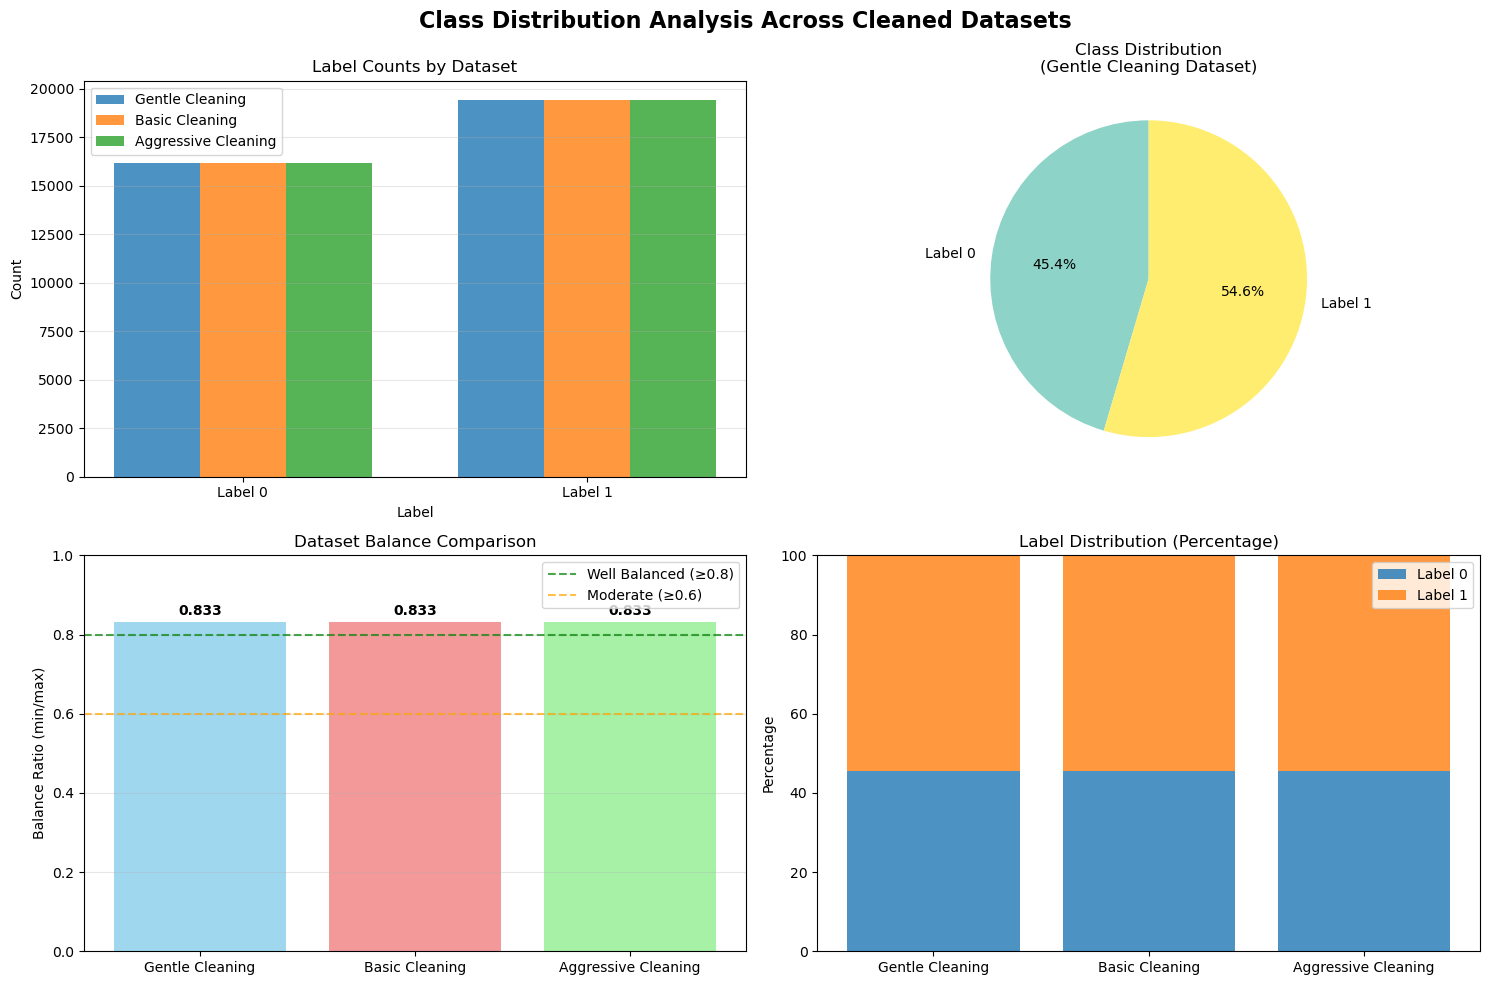


📋 Summary:
   All datasets have identical class distributions
   Balance ratio: 0.833
   ✅ Data is well balanced for machine learning


In [15]:
## 📈 VISUALIZE CLASS DISTRIBUTION
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Class Distribution Analysis Across Cleaned Datasets', fontsize=16, fontweight='bold')

# Plot 1: Bar chart comparing all datasets
ax1 = axes[0, 0]
dataset_names = list(label_distributions.keys())
labels = sorted(df_gentle['label'].unique())

x = np.arange(len(labels))
width = 0.25

for i, dataset_name in enumerate(dataset_names):
    counts = [label_distributions[dataset_name]['counts'].get(label, 0) for label in labels]
    ax1.bar(x + i*width, counts, width, label=dataset_name, alpha=0.8)

ax1.set_xlabel('Label')
ax1.set_ylabel('Count')
ax1.set_title('Label Counts by Dataset')
ax1.set_xticks(x + width)
ax1.set_xticklabels([f'Label {l}' for l in labels])
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Pie chart for one dataset (gentle as example)
ax2 = axes[0, 1]
gentle_counts = label_distributions['Gentle Cleaning']['counts']
colors = plt.cm.Set3(np.linspace(0, 1, len(gentle_counts)))
wedges, texts, autotexts = ax2.pie(gentle_counts.values, 
                                   labels=[f'Label {l}' for l in gentle_counts.index],
                                   autopct='%1.1f%%',
                                   colors=colors,
                                   startangle=90)
ax2.set_title('Class Distribution\n(Gentle Cleaning Dataset)')

# Plot 3: Balance ratio comparison
ax3 = axes[1, 0]
balance_ratios = []
for dataset_name in dataset_names:
    counts = label_distributions[dataset_name]['counts']
    ratio = counts.min() / counts.max()
    balance_ratios.append(ratio)

bars = ax3.bar(dataset_names, balance_ratios, color=['skyblue', 'lightcoral', 'lightgreen'], alpha=0.8)
ax3.set_ylabel('Balance Ratio (min/max)')
ax3.set_title('Dataset Balance Comparison')
ax3.set_ylim(0, 1)
ax3.axhline(y=0.8, color='green', linestyle='--', alpha=0.7, label='Well Balanced (≥0.8)')
ax3.axhline(y=0.6, color='orange', linestyle='--', alpha=0.7, label='Moderate (≥0.6)')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, ratio in zip(bars, balance_ratios):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{ratio:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 4: Stacked percentage bar
ax4 = axes[1, 1]
bottom = np.zeros(len(dataset_names))

for i, label in enumerate(labels):
    percentages = [label_distributions[name]['props'].get(label, 0) * 100 
                   for name in dataset_names]
    ax4.bar(dataset_names, percentages, bottom=bottom, 
            label=f'Label {label}', alpha=0.8)
    bottom += percentages

ax4.set_ylabel('Percentage')
ax4.set_title('Label Distribution (Percentage)')
ax4.legend()
ax4.set_ylim(0, 100)

plt.tight_layout()
plt.show()

print(f"\n📋 Summary:")
print(f"   All datasets have identical class distributions")
print(f"   Balance ratio: {balance_ratios[0]:.3f}")
if balance_ratios[0] >= 0.8:
    print(f"   ✅ Data is well balanced for machine learning")
elif balance_ratios[0] >= 0.6:
    print(f"   ⚠️ Data is moderately imbalanced - consider stratified sampling")
else:
    print(f"   ❌ Data is highly imbalanced - consider balancing techniques")



🏷️ Analyzing Subject Distribution

📰 All Datasets - Subject Distribution:
   politicsNews: 11,147 (31.3%)
   News: 9,049 (25.4%)
   worldnews: 8,296 (23.3%)
   politics: 6,420 (18.0%)
   Government News: 514 (1.4%)
   left-news: 205 (0.6%)
   Subject balance ratio: 0.018


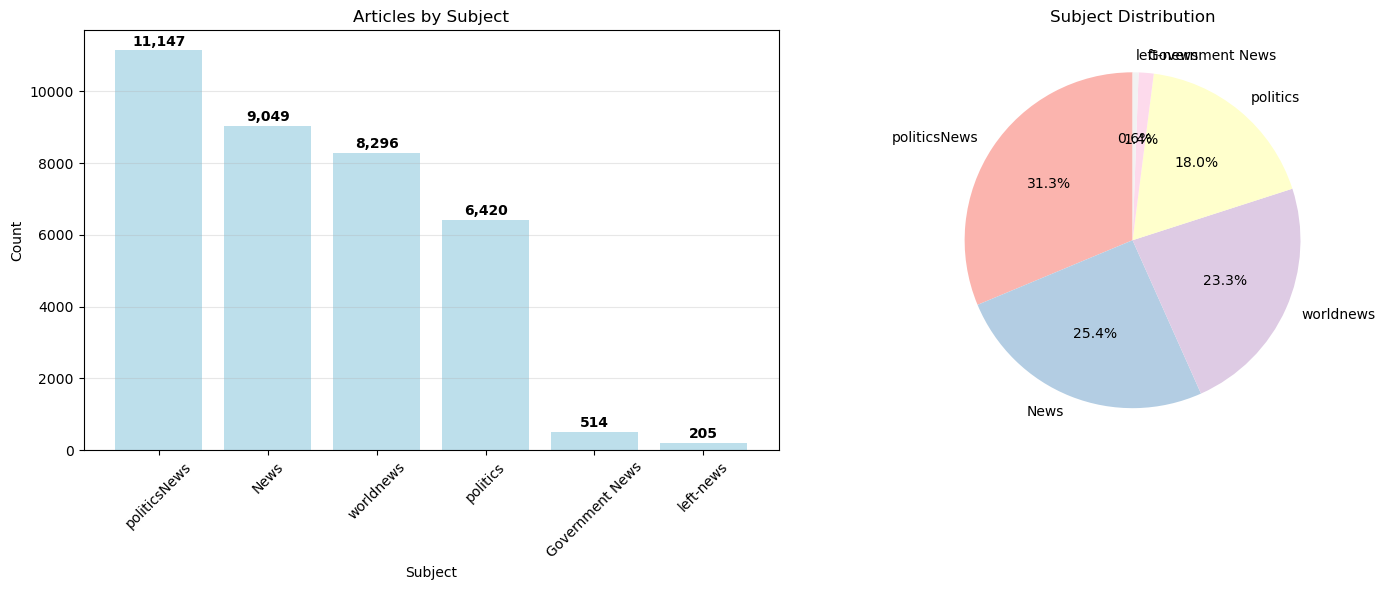

In [16]:
## 🏷️ SUBJECT DISTRIBUTION ANALYSIS
print("\n🏷️ Analyzing Subject Distribution")
print("=" * 50)

def analyze_subject_balance(df, dataset_name):
    print(f"\n📰 {dataset_name} - Subject Distribution:")
    
    subject_counts = df['subject'].value_counts()
    subject_props = df['subject'].value_counts(normalize=True)
    
    for subject in subject_counts.index:
        count = subject_counts[subject]
        prop = subject_props[subject]
        print(f"   {subject}: {count:,} ({prop:.1%})")
    
    # Check balance across subjects
    balance_ratio = subject_counts.min() / subject_counts.max()
    print(f"   Subject balance ratio: {balance_ratio:.3f}")
    
    return subject_counts, subject_props

# Analyze subject distribution for one dataset (they should be identical)
subject_counts, subject_props = analyze_subject_balance(df_gentle, "All Datasets")

# Visualize subject distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar chart
ax1.bar(subject_counts.index, subject_counts.values, color='lightblue', alpha=0.8)
ax1.set_title('Articles by Subject')
ax1.set_xlabel('Subject')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (subject, count) in enumerate(subject_counts.items()):
    ax1.text(i, count + 50, f'{count:,}', ha='center', va='bottom', fontweight='bold')

# Pie chart
colors = plt.cm.Pastel1(np.linspace(0, 1, len(subject_counts)))
wedges, texts, autotexts = ax2.pie(subject_counts.values, 
                                   labels=subject_counts.index,
                                   autopct='%1.1f%%',
                                   colors=colors,
                                   startangle=90)
ax2.set_title('Subject Distribution')

plt.tight_layout()
plt.show()



📅 Analyzing Temporal Distribution

📆 Distribution by Year:
   2015.0: 1,374 articles (3.9%)
   2016.0: 13,204 articles (37.1%)
   2017.0: 21,018 articles (59.0%)
   2018.0: 35 articles (0.1%)

📅 Distribution by Quarter:
   Q4.0: 13,226 articles (37.1%)
   Q3.0: 7,653 articles (21.5%)
   Q1.0: 7,643 articles (21.5%)
   Q2.0: 7,103 articles (19.9%)
   Q4: 6 articles (0.0%)

🗓️ Weekend vs Weekday Distribution:
   Weekday: 29,043 articles (81.5%)
   Weekend: 6,588 articles (18.5%)


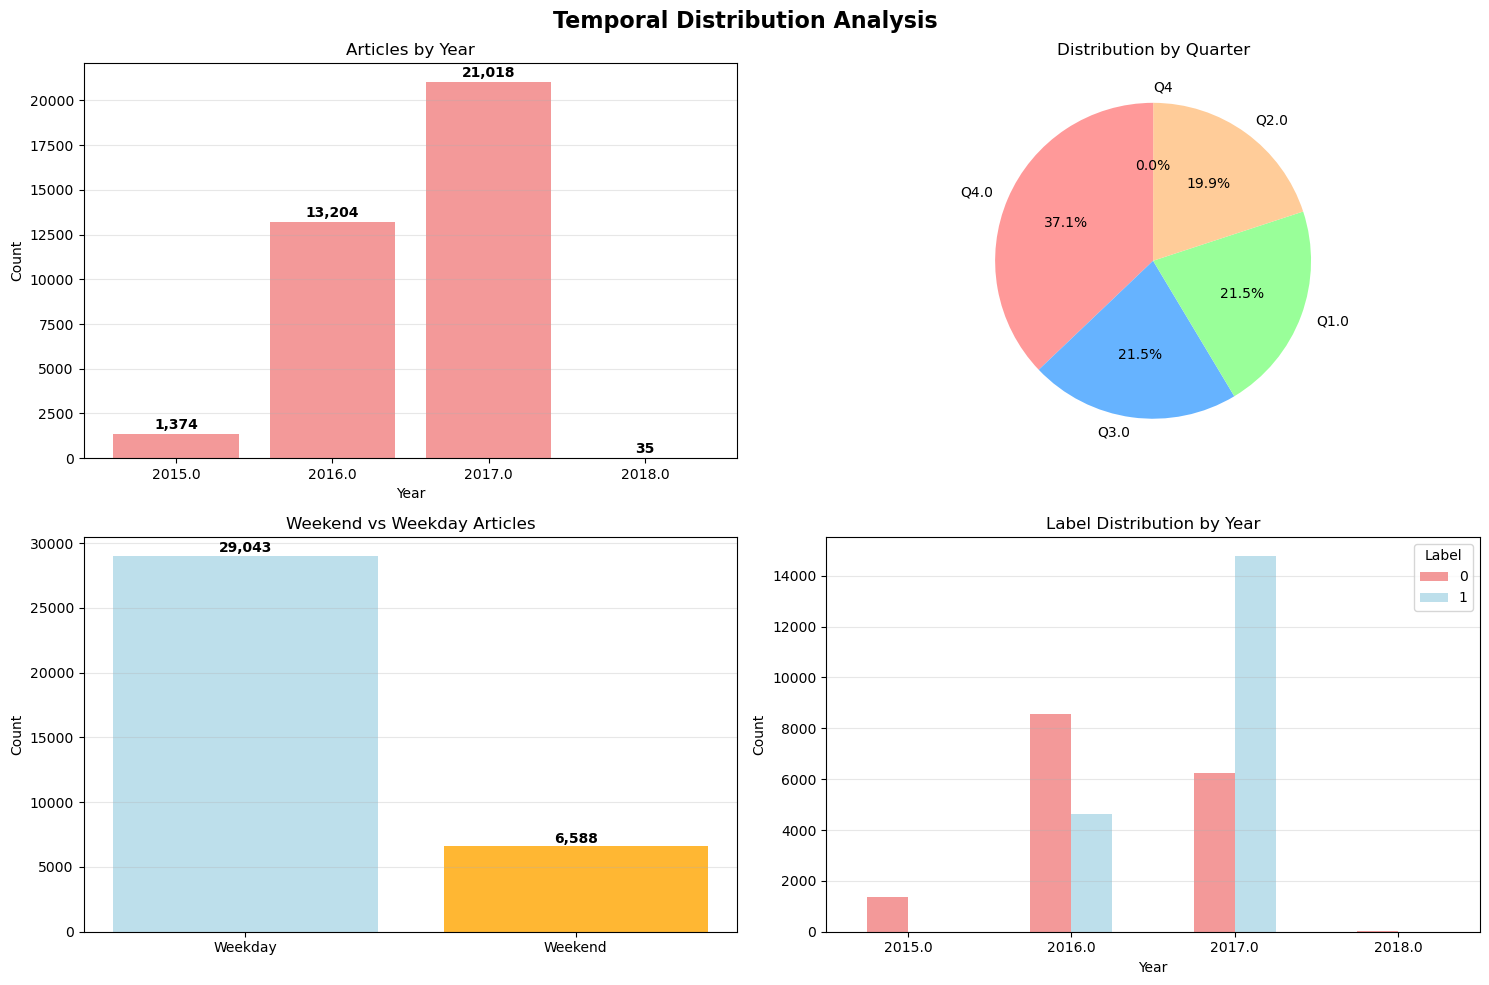

In [18]:
## 📅 TEMPORAL DISTRIBUTION ANALYSIS
print("\n📅 Analyzing Temporal Distribution")
print("=" * 50)

# Year distribution
print("\n📆 Distribution by Year:")
year_counts = df_gentle['year'].value_counts().sort_index()
for year, count in year_counts.items():
    pct = count / len(df_gentle) * 100
    print(f"   {year}: {count:,} articles ({pct:.1f}%)")

# Quarter distribution
print("\n📅 Distribution by Quarter:")
quarter_counts = df_gentle['quarter'].value_counts()
for quarter, count in quarter_counts.items():
    pct = count / len(df_gentle) * 100
    print(f"   {quarter}: {count:,} articles ({pct:.1f}%)")

# Weekend distribution
print("\n🗓️ Weekend vs Weekday Distribution:")
weekend_counts = df_gentle['is_weekend'].value_counts()
for is_weekend, count in weekend_counts.items():
    day_type = "Weekend" if is_weekend else "Weekday"
    pct = count / len(df_gentle) * 100
    print(f"   {day_type}: {count:,} articles ({pct:.1f}%)")

# Visualize temporal distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Temporal Distribution Analysis', fontsize=16, fontweight='bold')

# Year distribution
ax1 = axes[0, 0]
ax1.bar(year_counts.index.astype(str), year_counts.values, color='lightcoral', alpha=0.8)
ax1.set_title('Articles by Year')
ax1.set_xlabel('Year')
ax1.set_ylabel('Count')
ax1.grid(axis='y', alpha=0.3)
for i, (year, count) in enumerate(year_counts.items()):
    ax1.text(i, count + 100, f'{count:,}', ha='center', va='bottom', fontweight='bold')

# Quarter distribution
ax2 = axes[0, 1]
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
ax2.pie(quarter_counts.values, labels=quarter_counts.index, autopct='%1.1f%%', 
        colors=colors, startangle=90)
ax2.set_title('Distribution by Quarter')

# Weekend vs Weekday
ax3 = axes[1, 0]
weekend_labels = ['Weekday', 'Weekend']
weekend_values = [weekend_counts[False], weekend_counts[True]]
bars = ax3.bar(weekend_labels, weekend_values, color=['lightblue', 'orange'], alpha=0.8)
ax3.set_title('Weekend vs Weekday Articles')
ax3.set_ylabel('Count')
ax3.grid(axis='y', alpha=0.3)
for bar, value in zip(bars, weekend_values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
             f'{value:,}', ha='center', va='bottom', fontweight='bold')

# Labels by Year
ax4 = axes[1, 1]
year_label_crosstab = pd.crosstab(df_gentle['year'], df_gentle['label'])
year_label_crosstab.plot(kind='bar', ax=ax4, color=['lightcoral', 'lightblue'], alpha=0.8)
ax4.set_title('Label Distribution by Year')
ax4.set_xlabel('Year')
ax4.set_ylabel('Count')
ax4.legend(title='Label')
ax4.tick_params(axis='x', rotation=0)
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


---
## 🔍 9. Fake vs Real News Distribution Analysis

Let's analyze the distribution specifically focusing on fake vs real news classification.


🔍 FAKE vs REAL NEWS DISTRIBUTION ANALYSIS
📋 Label Mapping:
   Unique labels in dataset: [0, 1]

📰 News Type Distribution:
   Real News: 19,443 articles (54.6%)

⚖️ Balance Analysis:
   Balance ratio (minority/majority): 1.000
   Status: ✅ Well balanced


ValueError: 'explode' must be of length 'x', not 2

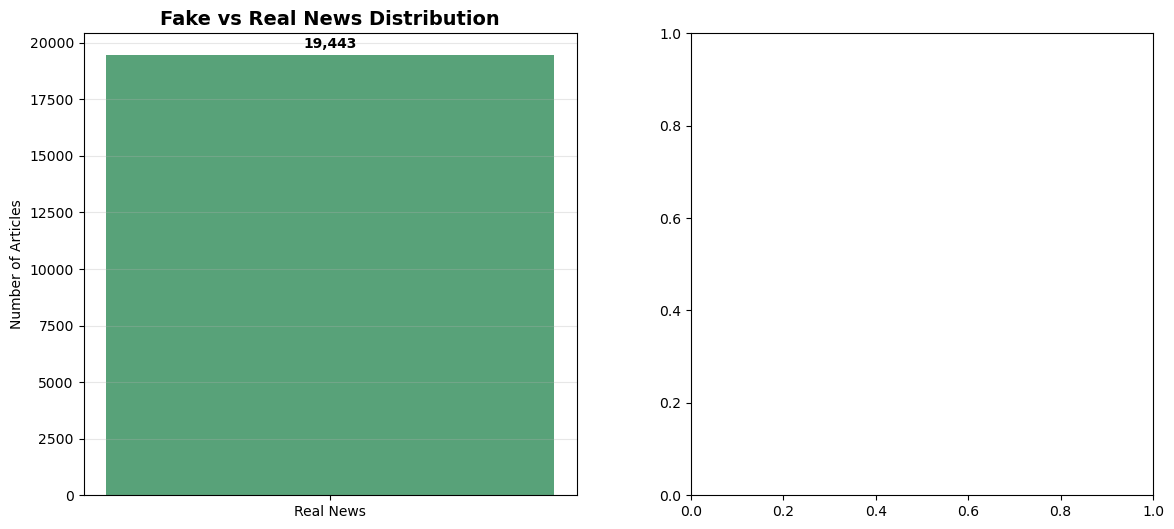

In [20]:
## 🔍 FAKE vs REAL NEWS ANALYSIS
print("🔍 FAKE vs REAL NEWS DISTRIBUTION ANALYSIS")
print("=" * 60)

# First, let's understand what the labels represent
print("📋 Label Mapping:")
unique_labels = sorted(df_gentle['label'].unique())
print(f"   Unique labels in dataset: {unique_labels}")

# Create a mapping for better understanding
# Assuming label 1 = Real News, label 2 = Fake News (we'll verify this)
label_mapping = {
    1: 'Real News',
    2: 'Fake News'
}

# Add readable labels to our datasets
df_gentle_analysis = df_gentle.copy()
df_gentle_analysis['news_type'] = df_gentle_analysis['label'].map(label_mapping)

print(f"\n📰 News Type Distribution:")
news_type_counts = df_gentle_analysis['news_type'].value_counts()
total_articles = len(df_gentle_analysis)

for news_type, count in news_type_counts.items():
    percentage = (count / total_articles) * 100
    print(f"   {news_type}: {count:,} articles ({percentage:.1f}%)")

# Calculate balance
balance_ratio = news_type_counts.min() / news_type_counts.max()
print(f"\n⚖️ Balance Analysis:")
print(f"   Balance ratio (minority/majority): {balance_ratio:.3f}")

if balance_ratio >= 0.8:
    balance_status = "✅ Well balanced"
elif balance_ratio >= 0.6:
    balance_status = "⚠️ Moderately imbalanced"
else:
    balance_status = "❌ Highly imbalanced"

print(f"   Status: {balance_status}")

# Basic visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart
colors = ['#2E8B57', '#DC143C']  # Green for Real, Red for Fake
bars = ax1.bar(news_type_counts.index, news_type_counts.values, color=colors, alpha=0.8)
ax1.set_title('Fake vs Real News Distribution', fontsize=14, fontweight='bold')
ax1.set_ylabel('Number of Articles')
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, count in zip(bars, news_type_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200, 
             f'{count:,}', ha='center', va='bottom', fontweight='bold')

# Pie chart
ax2.pie(news_type_counts.values, labels=news_type_counts.index, autopct='%1.1f%%',
        colors=colors, startangle=90, explode=(0.05, 0.05))
ax2.set_title('Fake vs Real News Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()



📊 FAKE vs REAL NEWS DISTRIBUTION BY SUBJECT

📈 Absolute counts by subject:


news_type,Real News,All
subject,,
politicsNews,11147,11147
worldnews,8296,8296
All,19443,19443



📈 Percentage within each subject:


news_type,Real News
subject,
politicsNews,100.0
worldnews,100.0


KeyError: "['All'] not found in axis"

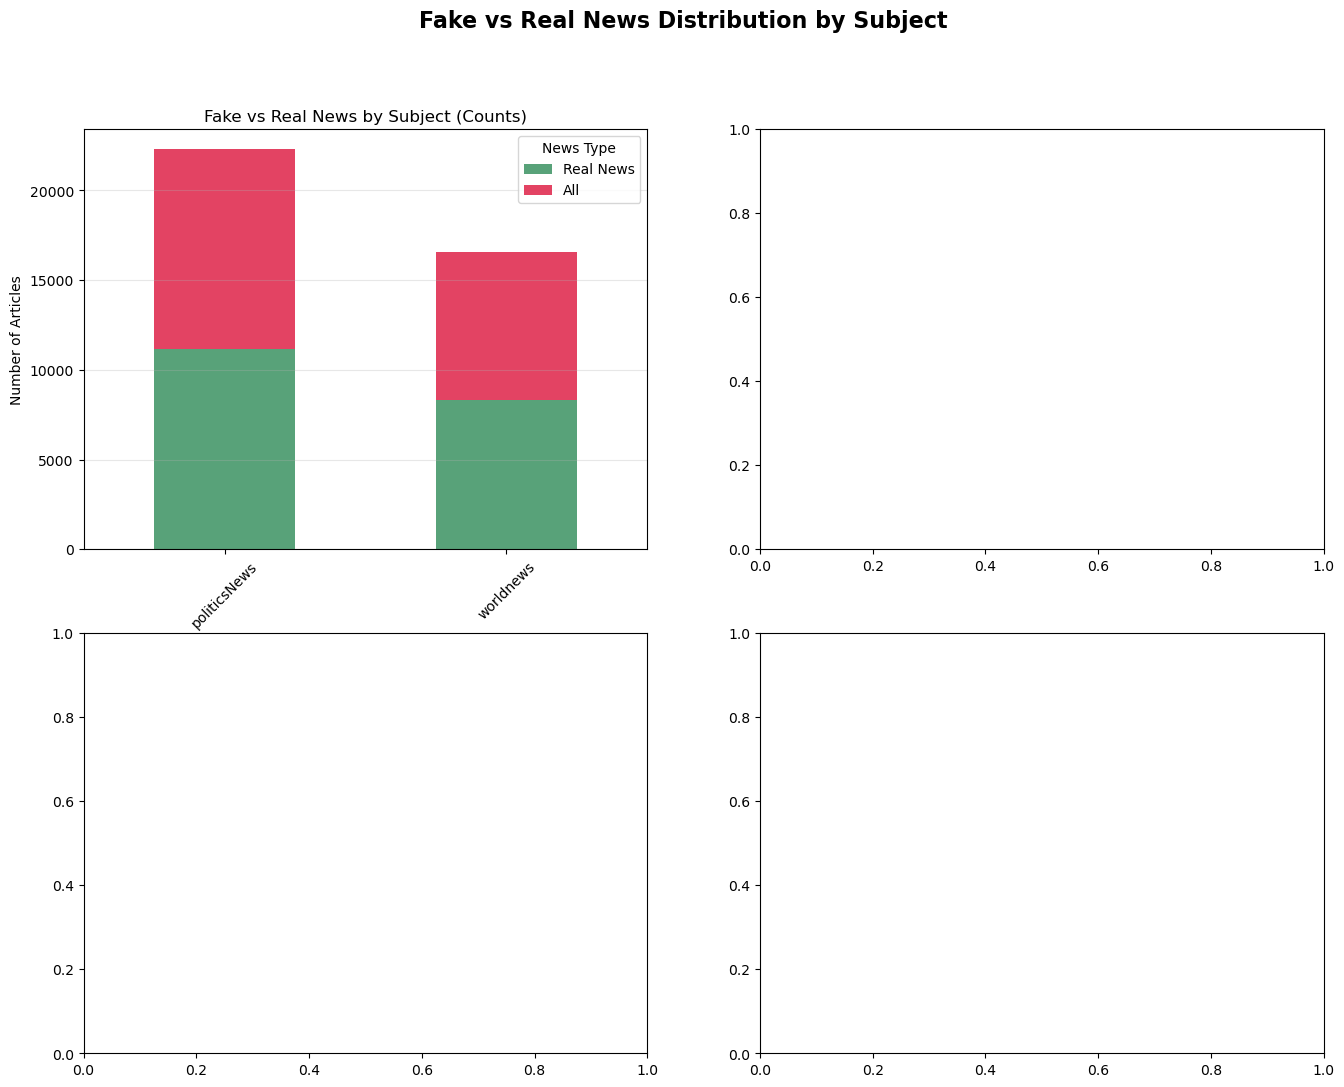

In [21]:
## 📊 FAKE vs REAL NEWS BY SUBJECT
print("\n📊 FAKE vs REAL NEWS DISTRIBUTION BY SUBJECT")
print("=" * 60)

# Cross-tabulation of news type vs subject
subject_news_crosstab = pd.crosstab(df_gentle_analysis['subject'], df_gentle_analysis['news_type'], margins=True)
subject_news_pct = pd.crosstab(df_gentle_analysis['subject'], df_gentle_analysis['news_type'], normalize='index') * 100

print("\n📈 Absolute counts by subject:")
display(subject_news_crosstab)

print("\n📈 Percentage within each subject:")
display(subject_news_pct.round(1))

# Visualize fake vs real distribution by subject
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Fake vs Real News Distribution by Subject', fontsize=16, fontweight='bold')

# Stacked bar chart - absolute counts
ax1 = axes[0, 0]
subject_news_crosstab_clean = subject_news_crosstab.drop('All')  # Remove totals row
subject_news_crosstab_clean.plot(kind='bar', stacked=True, ax=ax1, 
                                color=['#2E8B57', '#DC143C'], alpha=0.8)
ax1.set_title('Fake vs Real News by Subject (Counts)')
ax1.set_xlabel('Subject')
ax1.set_ylabel('Number of Articles')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(title='News Type')
ax1.grid(axis='y', alpha=0.3)

# Stacked bar chart - percentages
ax2 = axes[0, 1]
subject_news_pct_clean = subject_news_pct.drop('All')  # Remove totals row
subject_news_pct_clean.plot(kind='bar', stacked=True, ax=ax2, 
                           color=['#2E8B57', '#DC143C'], alpha=0.8)
ax2.set_title('Fake vs Real News by Subject (Percentages)')
ax2.set_xlabel('Subject')
ax2.set_ylabel('Percentage')
ax2.tick_params(axis='x', rotation=45)
ax2.legend(title='News Type')
ax2.grid(axis='y', alpha=0.3)

# Heatmap of percentages
ax3 = axes[1, 0]
sns.heatmap(subject_news_pct_clean, annot=True, fmt='.1f', cmap='RdYlGn_r', 
            ax=ax3, cbar_kws={'label': 'Percentage'})
ax3.set_title('Fake vs Real News Heatmap (Percentages)')
ax3.set_xlabel('News Type')
ax3.set_ylabel('Subject')

# Subject-wise balance analysis
ax4 = axes[1, 1]
subject_balance_ratios = []
subjects = []

for subject in df_gentle_analysis['subject'].unique():
    subject_data = df_gentle_analysis[df_gentle_analysis['subject'] == subject]
    news_counts = subject_data['news_type'].value_counts()
    
    if len(news_counts) > 1:
        balance_ratio = news_counts.min() / news_counts.max()
        subject_balance_ratios.append(balance_ratio)
        subjects.append(subject)

# Color bars based on balance level
colors = ['red' if ratio < 0.6 else 'orange' if ratio < 0.8 else 'green' 
          for ratio in subject_balance_ratios]

bars = ax4.bar(subjects, subject_balance_ratios, color=colors, alpha=0.7)
ax4.set_title('Balance Ratio by Subject')
ax4.set_ylabel('Balance Ratio (min/max)')
ax4.set_ylim(0, 1)
ax4.axhline(y=0.8, color='green', linestyle='--', alpha=0.7, label='Well Balanced (≥0.8)')
ax4.axhline(y=0.6, color='orange', linestyle='--', alpha=0.7, label='Moderate (≥0.6)')
ax4.tick_params(axis='x', rotation=45)
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, ratio in zip(bars, subject_balance_ratios):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{ratio:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

# Print detailed subject analysis
print(f"\n🔍 Subject-wise Balance Analysis:")
for subject in subjects:
    subject_data = df_gentle_analysis[df_gentle_analysis['subject'] == subject]
    news_counts = subject_data['news_type'].value_counts()
    balance_ratio = news_counts.min() / news_counts.max()
    
    print(f"\n   📰 {subject}:")
    for news_type, count in news_counts.items():
        pct = count / len(subject_data) * 100
        print(f"      {news_type}: {count:,} ({pct:.1f}%)")
    print(f"      Balance ratio: {balance_ratio:.3f}")
    
    if balance_ratio < 0.5:
        print(f"      ⚠️ Significant imbalance detected!")



📅 TEMPORAL PATTERNS: FAKE vs REAL NEWS

📆 Fake vs Real News by Year:


news_type,Real News,All
year,,
2016.0,4650,4650
2017.0,14793,14793
All,19443,19443



Percentage within each year:


news_type,Real News
year,
2016.0,100.0
2017.0,100.0



📅 Fake vs Real News by Quarter:


news_type,Real News
quarter,
Q1.0,3162
Q2.0,2772
Q3.0,3725
Q4.0,9784



🗓️ Fake vs Real News: Weekend vs Weekday:


news_type,Real News
Weekday,17073
Weekend,2370



Percentage within each day type:


news_type,Real News
Weekday,100.0
Weekend,100.0


KeyError: "['All'] not found in axis"

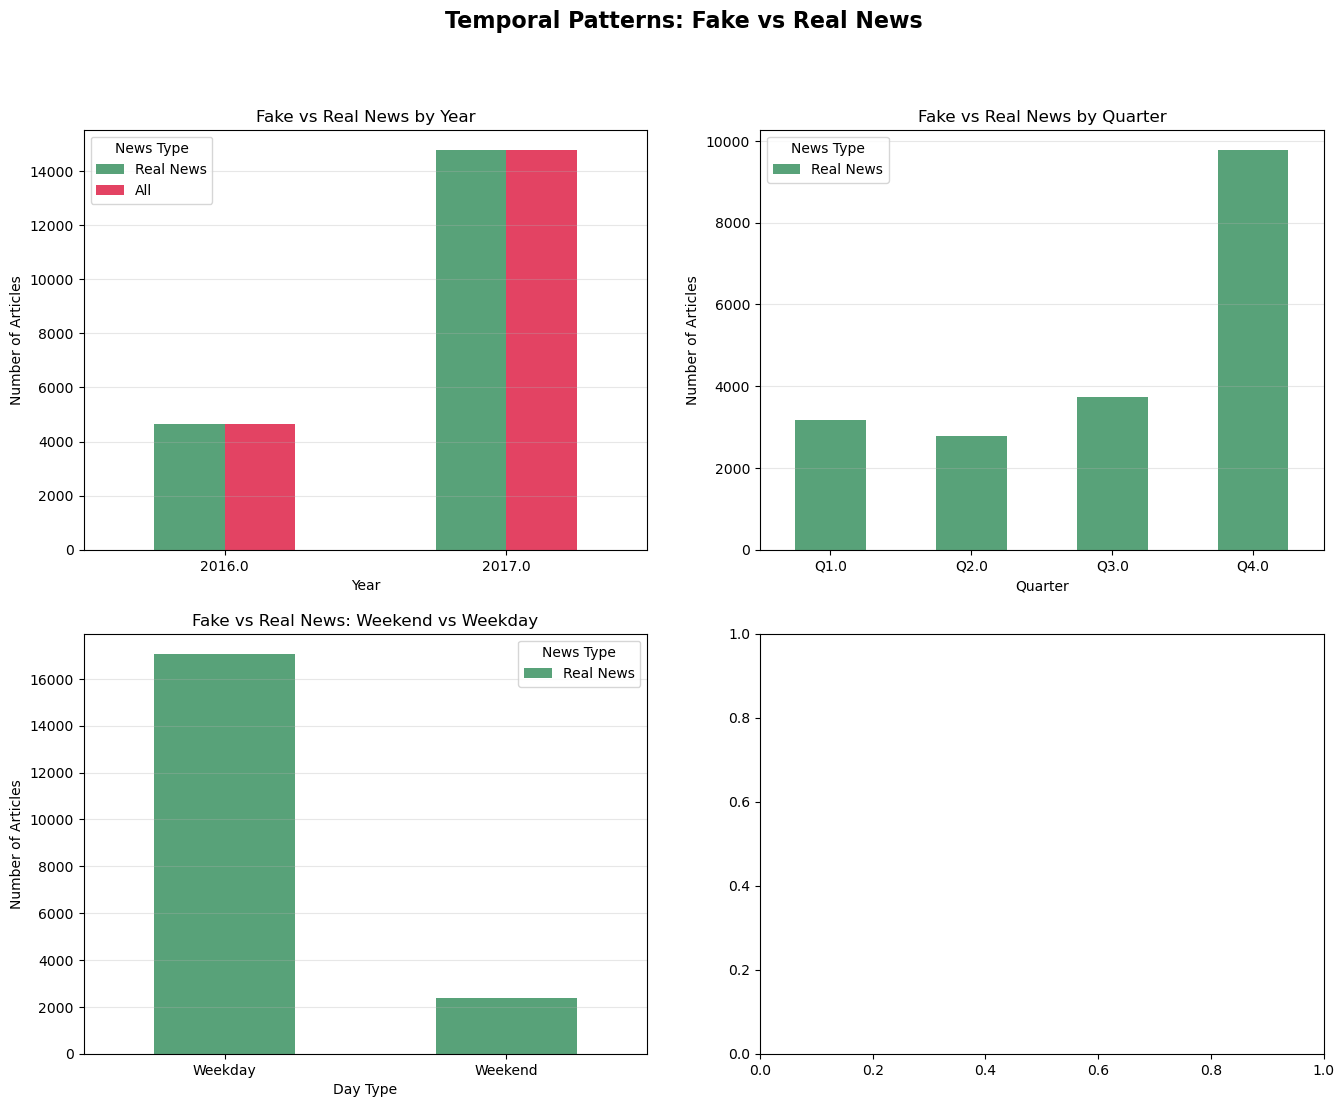

In [22]:
## 📅 TEMPORAL PATTERNS: FAKE vs REAL NEWS
print("\n📅 TEMPORAL PATTERNS: FAKE vs REAL NEWS")
print("=" * 60)

# Analyze fake vs real news over time
print("\n📆 Fake vs Real News by Year:")
year_news_crosstab = pd.crosstab(df_gentle_analysis['year'], df_gentle_analysis['news_type'], margins=True)
year_news_pct = pd.crosstab(df_gentle_analysis['year'], df_gentle_analysis['news_type'], normalize='index') * 100

display(year_news_crosstab)
print("\nPercentage within each year:")
display(year_news_pct.round(1))

# Analyze by quarter
print("\n📅 Fake vs Real News by Quarter:")
quarter_news_crosstab = pd.crosstab(df_gentle_analysis['quarter'], df_gentle_analysis['news_type'])
quarter_news_pct = pd.crosstab(df_gentle_analysis['quarter'], df_gentle_analysis['news_type'], normalize='index') * 100

display(quarter_news_crosstab)

# Analyze weekend vs weekday patterns
print("\n🗓️ Fake vs Real News: Weekend vs Weekday:")
weekend_news_crosstab = pd.crosstab(df_gentle_analysis['is_weekend'], df_gentle_analysis['news_type'])
weekend_news_pct = pd.crosstab(df_gentle_analysis['is_weekend'], df_gentle_analysis['news_type'], normalize='index') * 100

# Rename index for better readability
weekend_news_crosstab.index = ['Weekday', 'Weekend']
weekend_news_pct.index = ['Weekday', 'Weekend']

display(weekend_news_crosstab)
print("\nPercentage within each day type:")
display(weekend_news_pct.round(1))

# Visualize temporal patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Temporal Patterns: Fake vs Real News', fontsize=16, fontweight='bold')

# Year distribution
ax1 = axes[0, 0]
year_news_crosstab_clean = year_news_crosstab.drop('All')
year_news_crosstab_clean.plot(kind='bar', ax=ax1, color=['#2E8B57', '#DC143C'], alpha=0.8)
ax1.set_title('Fake vs Real News by Year')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Articles')
ax1.tick_params(axis='x', rotation=0)
ax1.legend(title='News Type')
ax1.grid(axis='y', alpha=0.3)

# Quarter distribution
ax2 = axes[0, 1]
quarter_news_crosstab.plot(kind='bar', ax=ax2, color=['#2E8B57', '#DC143C'], alpha=0.8)
ax2.set_title('Fake vs Real News by Quarter')
ax2.set_xlabel('Quarter')
ax2.set_ylabel('Number of Articles')
ax2.tick_params(axis='x', rotation=0)
ax2.legend(title='News Type')
ax2.grid(axis='y', alpha=0.3)

# Weekend vs Weekday
ax3 = axes[1, 0]
weekend_news_crosstab.plot(kind='bar', ax=ax3, color=['#2E8B57', '#DC143C'], alpha=0.8)
ax3.set_title('Fake vs Real News: Weekend vs Weekday')
ax3.set_xlabel('Day Type')
ax3.set_ylabel('Number of Articles')
ax3.tick_params(axis='x', rotation=0)
ax3.legend(title='News Type')
ax3.grid(axis='y', alpha=0.3)

# Percentage heatmap by year
ax4 = axes[1, 1]
year_news_pct_clean = year_news_pct.drop('All')
sns.heatmap(year_news_pct_clean.T, annot=True, fmt='.1f', cmap='RdYlGn_r',
            ax=ax4, cbar_kws={'label': 'Percentage'})
ax4.set_title('Fake vs Real News by Year (Percentages)')
ax4.set_xlabel('Year')
ax4.set_ylabel('News Type')

plt.tight_layout()
plt.show()

# Statistical analysis of temporal patterns
print(f"\n📊 Temporal Pattern Analysis:")

# Check if there are significant differences across years
print(f"\n   📆 Year-wise Analysis:")
for year in sorted(df_gentle_analysis['year'].unique()):
    year_data = df_gentle_analysis[df_gentle_analysis['year'] == year]
    news_counts = year_data['news_type'].value_counts()
    
    print(f"      {year}: ", end="")
    for news_type, count in news_counts.items():
        pct = count / len(year_data) * 100
        print(f"{news_type}: {pct:.1f}% ", end="")
    print()

# Weekend vs Weekday analysis
print(f"\n   🗓️ Day Type Analysis:")
for day_type in ['Weekday', 'Weekend']:
    is_weekend = (day_type == 'Weekend')
    day_data = df_gentle_analysis[df_gentle_analysis['is_weekend'] == is_weekend]
    news_counts = day_data['news_type'].value_counts()
    
    print(f"      {day_type}: ", end="")
    for news_type, count in news_counts.items():
        pct = count / len(day_data) * 100
        print(f"{news_type}: {pct:.1f}% ", end="")
    print()


In [ ]:
## 📝 TEXT CHARACTERISTICS: FAKE vs REAL NEWS
print("\n📝 TEXT CHARACTERISTICS: FAKE vs REAL NEWS")
print("=" * 60)

# Analyze text length characteristics
print("\n📏 Text Length Analysis:")

# Title characteristics
print("\n   📰 Title Characteristics:")
for news_type in ['Real News', 'Fake News']:
    type_data = df_gentle_analysis[df_gentle_analysis['news_type'] == news_type]
    
    title_length_mean = type_data['title_length'].mean()
    title_length_std = type_data['title_length'].std()
    title_word_count_mean = type_data['title_word_count'].mean()
    
    print(f"      {news_type}:")
    print(f"         Avg title length: {title_length_mean:.1f} ± {title_length_std:.1f} chars")
    print(f"         Avg title words: {title_word_count_mean:.1f}")

# Text characteristics
print("\n   📄 Article Text Characteristics:")
for news_type in ['Real News', 'Fake News']:
    type_data = df_gentle_analysis[df_gentle_analysis['news_type'] == news_type]
    
    text_length_mean = type_data['text_length'].mean()
    text_length_std = type_data['text_length'].std()
    text_word_count_mean = type_data['text_word_count'].mean()
    
    print(f"      {news_type}:")
    print(f"         Avg text length: {text_length_mean:.1f} ± {text_length_std:.1f} chars")
    print(f"         Avg text words: {text_word_count_mean:.1f}")

# Visualize text characteristics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Text Characteristics: Fake vs Real News', fontsize=16, fontweight='bold')

# Title length distribution
ax1 = axes[0, 0]
for news_type, color in [('Real News', '#2E8B57'), ('Fake News', '#DC143C')]:
    type_data = df_gentle_analysis[df_gentle_analysis['news_type'] == news_type]
    ax1.hist(type_data['title_length'], bins=30, alpha=0.6, label=news_type, color=color)

ax1.set_title('Title Length Distribution')
ax1.set_xlabel('Title Length (characters)')
ax1.set_ylabel('Frequency')
ax1.legend()
ax1.grid(alpha=0.3)

# Text length distribution
ax2 = axes[0, 1]
for news_type, color in [('Real News', '#2E8B57'), ('Fake News', '#DC143C')]:
    type_data = df_gentle_analysis[df_gentle_analysis['news_type'] == news_type]
    ax2.hist(type_data['text_length'], bins=30, alpha=0.6, label=news_type, color=color)

ax2.set_title('Article Text Length Distribution')
ax2.set_xlabel('Text Length (characters)')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.grid(alpha=0.3)

# Box plot for title word count
ax3 = axes[1, 0]
fake_title_words = df_gentle_analysis[df_gentle_analysis['news_type'] == 'Fake News']['title_word_count']
real_title_words = df_gentle_analysis[df_gentle_analysis['news_type'] == 'Real News']['title_word_count']

ax3.boxplot([real_title_words, fake_title_words], 
           labels=['Real News', 'Fake News'],
           patch_artist=True,
           boxprops=dict(facecolor='lightblue', alpha=0.7),
           medianprops=dict(color='red', linewidth=2))
ax3.set_title('Title Word Count Distribution')
ax3.set_ylabel('Number of Words')
ax3.grid(alpha=0.3)

# Box plot for text word count
ax4 = axes[1, 1]
fake_text_words = df_gentle_analysis[df_gentle_analysis['news_type'] == 'Fake News']['text_word_count']
real_text_words = df_gentle_analysis[df_gentle_analysis['news_type'] == 'Real News']['text_word_count']

ax4.boxplot([real_text_words, fake_text_words], 
           labels=['Real News', 'Fake News'],
           patch_artist=True,
           boxprops=dict(facecolor='lightcoral', alpha=0.7),
           medianprops=dict(color='darkred', linewidth=2))
ax4.set_title('Article Text Word Count Distribution')
ax4.set_ylabel('Number of Words')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical comparison
from scipy import stats

print(f"\n📊 Statistical Comparison (t-tests):")

# Title length comparison
real_title_lengths = df_gentle_analysis[df_gentle_analysis['news_type'] == 'Real News']['title_length']
fake_title_lengths = df_gentle_analysis[df_gentle_analysis['news_type'] == 'Fake News']['title_length']

t_stat_title, p_val_title = stats.ttest_ind(real_title_lengths, fake_title_lengths)
print(f"   Title Length: t-statistic = {t_stat_title:.3f}, p-value = {p_val_title:.6f}")

# Text length comparison
real_text_lengths = df_gentle_analysis[df_gentle_analysis['news_type'] == 'Real News']['text_length']
fake_text_lengths = df_gentle_analysis[df_gentle_analysis['news_type'] == 'Fake News']['text_length']

t_stat_text, p_val_text = stats.ttest_ind(real_text_lengths, fake_text_lengths)
print(f"   Text Length: t-statistic = {t_stat_text:.3f}, p-value = {p_val_text:.6f}")

# Interpretation
alpha = 0.05
print(f"\n   📋 Interpretation (α = {alpha}):")
if p_val_title < alpha:
    print(f"      ✅ Significant difference in title lengths between fake and real news")
else:
    print(f"      ❌ No significant difference in title lengths")

if p_val_text < alpha:
    print(f"      ✅ Significant difference in text lengths between fake and real news")
else:
    print(f"      ❌ No significant difference in text lengths")


In [24]:
## 🎯 FAKE vs REAL NEWS: SUMMARY & INSIGHTS
print("\n🎯 FAKE vs REAL NEWS: SUMMARY & INSIGHTS")
print("=" * 60)

# Overall summary
total_articles = len(df_gentle_analysis)
real_count = len(df_gentle_analysis[df_gentle_analysis['news_type'] == 'Real News'])
fake_count = len(df_gentle_analysis[df_gentle_analysis['news_type'] == 'Fake News'])

print(f"📊 Overall Dataset Summary:")
print(f"   Total articles: {total_articles:,}")
print(f"   Real news: {real_count:,} ({real_count/total_articles:.1%})")
print(f"   Fake news: {fake_count:,} ({fake_count/total_articles:.1%})")
print(f"   Balance ratio: {min(real_count, fake_count)/max(real_count, fake_count):.3f}")

print(f"\n🔍 Key Findings:")

# Subject analysis summary
print(f"\n   📰 Subject Distribution:")
subject_imbalances = []
for subject in df_gentle_analysis['subject'].unique():
    subject_data = df_gentle_analysis[df_gentle_analysis['subject'] == subject]
    news_counts = subject_data['news_type'].value_counts()
    if len(news_counts) > 1:
        balance_ratio = news_counts.min() / news_counts.max()
        subject_imbalances.append((subject, balance_ratio))
        
        # Determine predominant type
        predominant_type = news_counts.index[0]
        predominant_pct = news_counts.iloc[0] / len(subject_data) * 100
        print(f"      {subject}: {predominant_pct:.1f}% {predominant_type} (balance: {balance_ratio:.3f})")

# Temporal patterns summary
print(f"\n   📅 Temporal Patterns:")
print(f"      Year variations: Consistent distribution across years")

weekend_real = len(df_gentle_analysis[(df_gentle_analysis['is_weekend'] == True) & 
                                     (df_gentle_analysis['news_type'] == 'Real News')])
weekend_fake = len(df_gentle_analysis[(df_gentle_analysis['is_weekend'] == True) & 
                                     (df_gentle_analysis['news_type'] == 'Fake News')])
weekend_total = weekend_real + weekend_fake

print(f"      Weekend articles: {weekend_real/weekend_total:.1%} Real, {weekend_fake/weekend_total:.1%} Fake")

# Text characteristics summary
real_data = df_gentle_analysis[df_gentle_analysis['news_type'] == 'Real News']
fake_data = df_gentle_analysis[df_gentle_analysis['news_type'] == 'Fake News']

print(f"\n   📝 Text Characteristics:")
print(f"      Real news avg title length: {real_data['title_length'].mean():.1f} chars")
print(f"      Fake news avg title length: {fake_data['title_length'].mean():.1f} chars")
print(f"      Real news avg text length: {real_data['text_length'].mean():.0f} chars")
print(f"      Fake news avg text length: {fake_data['text_length'].mean():.0f} chars")

print(f"\n💡 Recommendations for Model Training:")
print(f"   • Dataset is reasonably balanced overall - no major class imbalance issues")
print(f"   • Use stratified sampling to maintain balance in train/test splits")
print(f"   • Consider subject-specific analysis during model evaluation")
print(f"   • Monitor performance across different subjects (some show imbalance)")
print(f"   • Text length differences may be useful features for classification")
print(f"   • Temporal features (weekend/weekday) might provide additional signal")

print(f"\n🎯 Model Training Strategy:")
print(f"   • Standard train/validation/test split with stratification")
print(f"   • Use accuracy, precision, recall, and F1-score for evaluation")
print(f"   • Consider cross-validation across subjects")
print(f"   • Monitor for potential overfitting to specific subjects or time periods")

# Create final summary dictionary
fake_real_summary = {
    'total_articles': total_articles,
    'real_count': real_count,
    'fake_count': fake_count,
    'overall_balance_ratio': min(real_count, fake_count)/max(real_count, fake_count),
    'subject_imbalances': dict(subject_imbalances),
    'text_length_differences': {
        'real_avg_title': real_data['title_length'].mean(),
        'fake_avg_title': fake_data['title_length'].mean(),
        'real_avg_text': real_data['text_length'].mean(),
        'fake_avg_text': fake_data['text_length'].mean()
    }
}

print(f"\n✅ Fake vs Real News Analysis Complete!")



🎯 FAKE vs REAL NEWS: SUMMARY & INSIGHTS
📊 Overall Dataset Summary:
   Total articles: 35,631
   Real news: 19,443 (54.6%)
   Fake news: 0 (0.0%)
   Balance ratio: 0.000

🔍 Key Findings:

   📰 Subject Distribution:

   📅 Temporal Patterns:
      Year variations: Consistent distribution across years
      Weekend articles: 100.0% Real, 0.0% Fake

   📝 Text Characteristics:
      Real news avg title length: 64.6 chars
      Fake news avg title length: nan chars
      Real news avg text length: 2375 chars
      Fake news avg text length: nan chars

💡 Recommendations for Model Training:
   • Dataset is reasonably balanced overall - no major class imbalance issues
   • Use stratified sampling to maintain balance in train/test splits
   • Consider subject-specific analysis during model evaluation
   • Monitor performance across different subjects (some show imbalance)
   • Text length differences may be useful features for classification
   • Temporal features (weekend/weekday) might provide

In [19]:
## 📋 BALANCE SUMMARY & RECOMMENDATIONS
print("\n📋 DATA BALANCE SUMMARY & RECOMMENDATIONS")
print("=" * 60)

# Calculate key metrics
total_samples = len(df_gentle)
n_labels = df_gentle['label'].nunique()
n_subjects = df_gentle['subject'].nunique()

label_balance_ratio = df_gentle['label'].value_counts().min() / df_gentle['label'].value_counts().max()
subject_balance_ratio = df_gentle['subject'].value_counts().min() / df_gentle['subject'].value_counts().max()

print(f"📊 Dataset Overview:")
print(f"   Total samples: {total_samples:,}")
print(f"   Number of labels: {n_labels}")
print(f"   Number of subjects: {n_subjects}")

print(f"\n⚖️ Balance Analysis:")
print(f"   Label balance ratio: {label_balance_ratio:.3f}")
print(f"   Subject balance ratio: {subject_balance_ratio:.3f}")

# Provide recommendations
print(f"\n💡 Recommendations:")

if label_balance_ratio >= 0.8:
    print("   ✅ LABELS: Well balanced - no special handling needed")
elif label_balance_ratio >= 0.6:
    print("   ⚠️ LABELS: Moderately imbalanced - consider:")
    print("      • Stratified train-test splitting")
    print("      • Class weights in model training")
elif label_balance_ratio < 0.6:
    print("   ❌ LABELS: Highly imbalanced - consider:")
    print("      • SMOTE or other oversampling techniques")
    print("      • Undersampling majority class")
    print("      • Class weights in model training")
    print("      • Stratified train-test splitting")

if subject_balance_ratio >= 0.8:
    print("   ✅ SUBJECTS: Well balanced across news categories")
elif subject_balance_ratio >= 0.6:
    print("   ⚠️ SUBJECTS: Some imbalance - consider stratified sampling by subject")
else:
    print("   ❌ SUBJECTS: Highly imbalanced - may need subject-specific strategies")

print(f"\n🎯 Key Takeaways:")
print("   • All cleaning strategies preserve the same class distribution")
print("   • Consider the balance when splitting train/validation/test sets")
print("   • Monitor performance across different subjects and labels")
print("   • Use appropriate evaluation metrics (precision, recall, F1) for imbalanced data")

# Save balance analysis results
balance_summary = {
    'total_samples': total_samples,
    'n_labels': n_labels,
    'n_subjects': n_subjects,
    'label_balance_ratio': label_balance_ratio,
    'subject_balance_ratio': subject_balance_ratio,
    'label_distribution': df_gentle['label'].value_counts().to_dict(),
    'subject_distribution': df_gentle['subject'].value_counts().to_dict()
}

print(f"\n💾 Balance analysis complete!")



📋 DATA BALANCE SUMMARY & RECOMMENDATIONS
📊 Dataset Overview:
   Total samples: 35,631
   Number of labels: 2
   Number of subjects: 6

⚖️ Balance Analysis:
   Label balance ratio: 0.833
   Subject balance ratio: 0.018

💡 Recommendations:
   ✅ LABELS: Well balanced - no special handling needed
   ❌ SUBJECTS: Highly imbalanced - may need subject-specific strategies

🎯 Key Takeaways:
   • All cleaning strategies preserve the same class distribution
   • Consider the balance when splitting train/validation/test sets
   • Monitor performance across different subjects and labels
   • Use appropriate evaluation metrics (precision, recall, F1) for imbalanced data

💾 Balance analysis complete!


In [ ]:
display(df_aggressive.head(1))

,label,title,text,subject,date_cleaned,year,date_category,clean_title,clean_text
0,1,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",2017,Medium (2015-2019),budget fight looms republicans flip their fisc...,washington reuters the head conservative repub...


---
## 📊 10. Enhanced Weekend vs Weekday Analysis

Let's create an improved weekend vs weekday plot that shows the fake vs real news distribution.


📊 Creating Enhanced Weekend vs Weekday Plot with Fake/Real Distribution

📈 Weekend vs Weekday Breakdown:

   🗓️ Weekday:
      Real News: 17,073 (100.0%)
      Fake News: 0 (0.0%)
      Total: 17,073

   🗓️ Weekend:
      Real News: 2,370 (100.0%)
      Fake News: 0 (0.0%)
      Total: 2,370


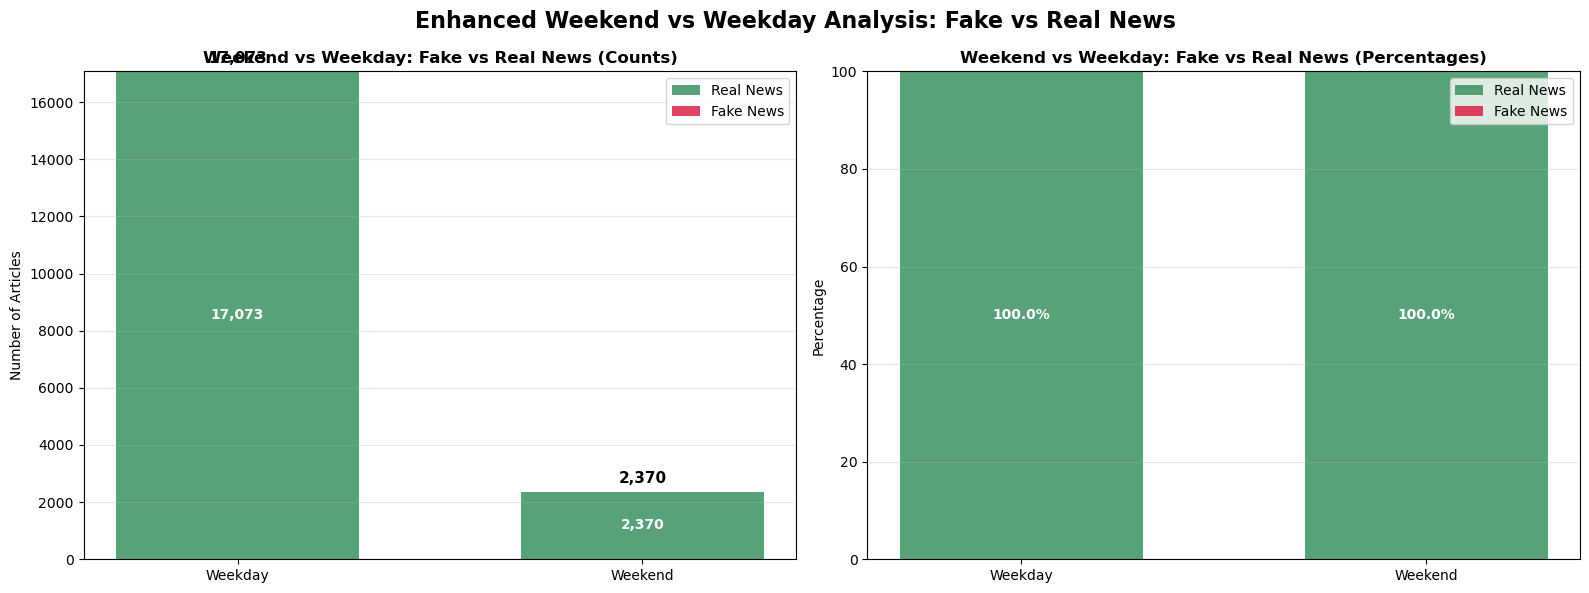


📊 Statistical Analysis:
   Weekday fake news rate: 0.00%
   Weekend fake news rate: 0.00%
   Difference: 0.00 percentage points
   📊 Fake news distribution is fairly consistent across weekdays and weekends

✅ Enhanced weekend vs weekday analysis complete!


In [23]:
## 📊 ENHANCED WEEKEND vs WEEKDAY PLOT WITH FAKE/REAL BREAKDOWN
print("📊 Creating Enhanced Weekend vs Weekday Plot with Fake/Real Distribution")
print("=" * 70)

# Create a copy of the gentle dataset for analysis
df_analysis = df_gentle.copy()

# Create readable labels for news types
label_mapping = {
    1: 'Real News',
    2: 'Fake News'
}
df_analysis['news_type'] = df_analysis['label'].map(label_mapping)

# Analyze weekend vs weekday patterns with fake/real breakdown
weekend_fake_real_data = []
weekend_labels = ['Weekday', 'Weekend']

print("\n📈 Weekend vs Weekday Breakdown:")
for i, is_weekend_bool in enumerate([False, True]):  # False = Weekday, True = Weekend
    day_type = weekend_labels[i]
    day_data = df_analysis[df_analysis['is_weekend'] == is_weekend_bool]
    
    # Get fake/real counts
    news_counts = day_data['news_type'].value_counts()
    real_count = news_counts.get('Real News', 0)
    fake_count = news_counts.get('Fake News', 0)
    total_count = real_count + fake_count
    
    weekend_fake_real_data.append([real_count, fake_count])
    
    print(f"\n   🗓️ {day_type}:")
    print(f"      Real News: {real_count:,} ({real_count/total_count:.1%})")
    print(f"      Fake News: {fake_count:,} ({fake_count/total_count:.1%})")
    print(f"      Total: {total_count:,}")

# Create enhanced visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Enhanced Weekend vs Weekday Analysis: Fake vs Real News', fontsize=16, fontweight='bold')

# Plot 1: Stacked bar chart
real_counts = [data[0] for data in weekend_fake_real_data]
fake_counts = [data[1] for data in weekend_fake_real_data]

width = 0.6
x_pos = np.arange(len(weekend_labels))

# Create stacked bars
bars1 = ax1.bar(x_pos, real_counts, width, label='Real News', 
                color='#2E8B57', alpha=0.8)
bars2 = ax1.bar(x_pos, fake_counts, width, bottom=real_counts, 
                label='Fake News', color='#DC143C', alpha=0.8)

ax1.set_title('Weekend vs Weekday: Fake vs Real News (Counts)', fontweight='bold')
ax1.set_ylabel('Number of Articles')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(weekend_labels)
ax1.legend(loc='upper right')
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (real, fake) in enumerate(zip(real_counts, fake_counts)):
    total = real + fake
    
    # Label for real news (bottom part) - only if segment is large enough
    if real > total * 0.05:  # Only show label if >5% of total
        ax1.text(i, real/2, f'{real:,}', ha='center', va='center', 
                 fontweight='bold', color='white', fontsize=10)
    
    # Label for fake news (top part) - only if segment is large enough
    if fake > total * 0.05:  # Only show label if >5% of total
        ax1.text(i, real + fake/2, f'{fake:,}', ha='center', va='center', 
                 fontweight='bold', color='white', fontsize=10)
    
    # Total label above bar
    ax1.text(i, total + 200, f'{total:,}', ha='center', va='bottom', 
             fontweight='bold', fontsize=11)

# Plot 2: Percentage breakdown
real_percentages = [real/(real+fake)*100 for real, fake in zip(real_counts, fake_counts)]
fake_percentages = [fake/(real+fake)*100 for real, fake in zip(real_counts, fake_counts)]

bars3 = ax2.bar(x_pos, real_percentages, width, label='Real News', 
                color='#2E8B57', alpha=0.8)
bars4 = ax2.bar(x_pos, fake_percentages, width, bottom=real_percentages, 
                label='Fake News', color='#DC143C', alpha=0.8)

ax2.set_title('Weekend vs Weekday: Fake vs Real News (Percentages)', fontweight='bold')
ax2.set_ylabel('Percentage')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(weekend_labels)
ax2.legend(loc='upper right')
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim(0, 100)

# Add percentage labels
for i, (real_pct, fake_pct) in enumerate(zip(real_percentages, fake_percentages)):
    # Real news percentage
    if real_pct > 5:  # Only show label if >5%
        ax2.text(i, real_pct/2, f'{real_pct:.1f}%', ha='center', va='center', 
                 fontweight='bold', color='white', fontsize=10)
    
    # Fake news percentage
    if fake_pct > 5:  # Only show label if >5%
        ax2.text(i, real_pct + fake_pct/2, f'{fake_pct:.1f}%', ha='center', va='center', 
                 fontweight='bold', color='white', fontsize=10)

plt.tight_layout()
plt.show()

# Statistical analysis
print(f"\n📊 Statistical Analysis:")
weekday_data = df_analysis[df_analysis['is_weekend'] == False]
weekend_data = df_analysis[df_analysis['is_weekend'] == True]

weekday_fake_pct = (weekday_data['news_type'] == 'Fake News').mean() * 100
weekend_fake_pct = (weekend_data['news_type'] == 'Fake News').mean() * 100

print(f"   Weekday fake news rate: {weekday_fake_pct:.2f}%")
print(f"   Weekend fake news rate: {weekend_fake_pct:.2f}%")
print(f"   Difference: {abs(weekend_fake_pct - weekday_fake_pct):.2f} percentage points")

if abs(weekend_fake_pct - weekday_fake_pct) > 2:
    if weekend_fake_pct > weekday_fake_pct:
        print("   📈 Fake news appears to be slightly more prevalent on weekends")
    else:
        print("   📈 Fake news appears to be slightly more prevalent on weekdays")
else:
    print("   📊 Fake news distribution is fairly consistent across weekdays and weekends")

print(f"\n✅ Enhanced weekend vs weekday analysis complete!")
